# Autoregressive Image Modeling

**Goal**: implement PixelCNN(++), and understand the autoregressive convolutions and discrete logistics

In [1]:
USE_NOTEBOOK = True

## Standard libraries
import os
import json
import math
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
if USE_NOTEBOOK:
    plt.set_cmap('cividis')
    %matplotlib inline 
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns

## Progress bar
if USE_NOTEBOOK:
    from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [2]:
class MaskedConvolution(nn.Module):
    
    def __init__(self, c_in, c_out, mask, **kwargs):
        super().__init__()
        self.register_buffer('mask', mask[None,None])
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)
        
    def forward(self, x):
        self.conv.weight.data *= self.mask
        return self.conv(x)

In [3]:
class VerticalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0
        if mask_center:
            mask[kernel_size//2,:] = 0
        super().__init__(c_in, c_out, mask, **kwargs)
        
class HorizontalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0
        if mask_center:
            mask[0,kernel_size//2] = 0
        super().__init__(c_in, c_out, mask, **kwargs)

In [4]:
class GatedMaskedConv(nn.Module):
    
    def __init__(self, c_in, **kwargs):
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)
    
    def forward(self, v_stack, h_stack):
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)
        
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack
        
        return v_stack_out, h_stack_out

## Visualizing the receptive field

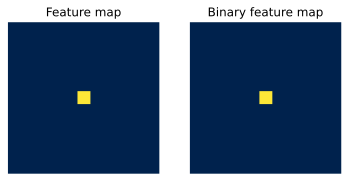

In [5]:
img = torch.zeros(11, 11)
img[img.shape[0]//2, img.shape[1]//2] = 1

if USE_NOTEBOOK:
    def show_recep_field(img):
        img = img.squeeze().cpu().numpy()
        fig, ax = plt.subplots(1,2)
        pos = ax[0].imshow(img)
        ax[1].imshow(img>0)
        show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
        if show_center:
            center_pixel = np.zeros(img.shape + (4,))
            center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0]) 
        for i in range(2):
            ax[i].axis('off')
            if show_center:
                ax[i].imshow(center_pixel)
        ax[0].set_title("Feature map")
        ax[1].set_title("Binary feature map")
        plt.show()
        plt.close()
else:
    def show_recep_field(img):
        pass

show_recep_field(img)

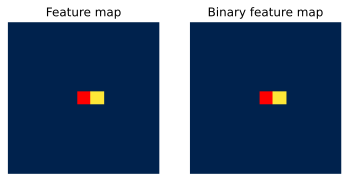

In [6]:
horiz_conv = HorizontalStackConvolution(1, 1, mask_center=True)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
with torch.no_grad():
    horiz_img = horiz_conv(img[None,None])
show_recep_field(horiz_img)

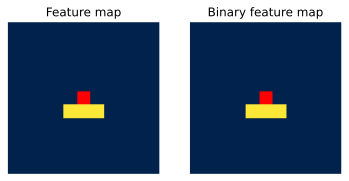

In [7]:
vert_conv = VerticalStackConvolution(1, 1, mask_center=True)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)
with torch.no_grad():
    vert_img = vert_conv(img[None,None])
show_recep_field(vert_img)

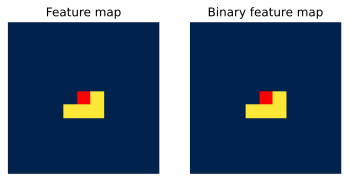

In [8]:
horiz_img = vert_img + horiz_img
show_recep_field(horiz_img)

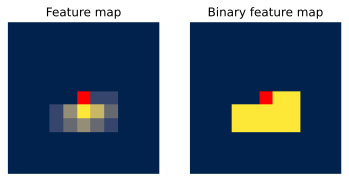

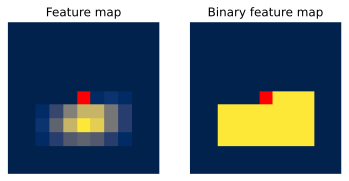

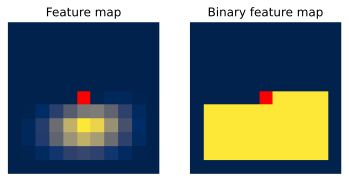

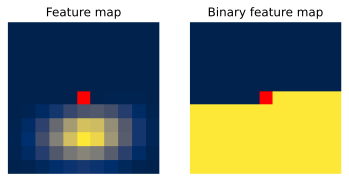

In [9]:
for _ in range(4):
    horiz_conv = HorizontalStackConvolution(1, 1, mask_center=False)
    horiz_conv.conv.weight.data.fill_(1)
    horiz_conv.conv.bias.data.fill_(0)
    vert_conv = VerticalStackConvolution(1, 1, mask_center=False)
    vert_conv.conv.weight.data.fill_(1)
    vert_conv.conv.bias.data.fill_(0)
    with torch.no_grad():
        vert_img = vert_conv(vert_img)
        horiz_img = horiz_conv(horiz_img) + vert_img
    show_recep_field(horiz_img)

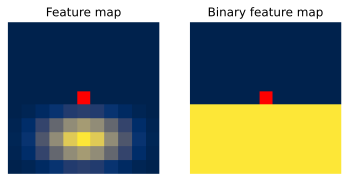

In [10]:
show_recep_field(vert_img)

## PixelCNN

In [11]:
class PixelCNN(nn.Module):
    
    def __init__(self, c_in, c_hidden, num_layers=4):
        super().__init__()
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        
        if num_layers == 7:
            self.conv_layers = nn.ModuleList([
                GatedMaskedConv(c_hidden),
                GatedMaskedConv(c_hidden, dilation=2),
                GatedMaskedConv(c_hidden),
                GatedMaskedConv(c_hidden, dilation=4),
                GatedMaskedConv(c_hidden),
                GatedMaskedConv(c_hidden, dilation=2),
                GatedMaskedConv(c_hidden)
            ])
        else:
            self.conv_layers = nn.ModuleList([GatedMaskedConv(c_hidden) for _ in range(num_layers)])
        
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)
        
    def forward(self, x):
        x = (x.float() / 255.0) * 2 - 1
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        
        out = self.conv_out(F.elu(h_stack))
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out
    
    def calc_likelihood(self, x):
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd
        
    def sample(self, img_shape, img=None):
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        self.eval()
        with torch.no_grad():
            for h in (tqdm(range(img_shape[2]), leave=False) if USE_NOTEBOOK else range(img_shape[2])):
                for w in range(img_shape[3]):
                    for c in range(img_shape[1]):
                        if (img[:,c,h,w] != -1).all().item():
                            continue
                        pred = self.forward(img)
                        probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                        img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

In [12]:
model = PixelCNN(1, 64, num_layers=7)

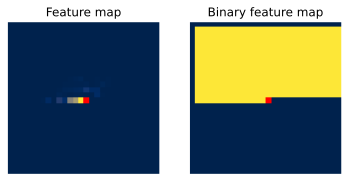

In [13]:
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = model(inp)
out[0,:,0,14,14].sum().backward()
abs_grads = inp.grad.abs()
show_recep_field(abs_grads)

In [14]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
set_seed(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=0)

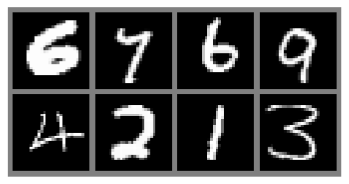

In [15]:
if USE_NOTEBOOK:

    def show_imgs(imgs):
        num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
        imgs = torchvision.utils.make_grid(imgs, nrow=min(num_imgs, 4), pad_value=128)
        np_imgs = imgs.cpu().numpy()
        plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
        plt.axis('off')
        plt.show()
        plt.close()

    show_imgs([train_set[i][0] for i in range(8)])

else:
    def show_imgs(imgs):
        pass

In [16]:
def train_model(model, model_name, max_epochs=80):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99) # Every epoch, we multiply the LR by 0.95
    train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)
    
    print("Start training %s..." % model_name)
    
    avg_bpd = 8.0
    
    val_scores = []
    for epoch in range(max_epochs):
        pbar = tqdm(train_loader, leave=False) if USE_NOTEBOOK else train_loader
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            bpd = model.calc_likelihood(imgs).mean()
            bpd.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            avg_bpd = 0.9 * avg_bpd + 0.1 * bpd.item()
            if USE_NOTEBOOK:
                pbar.set_description("[Epoch %i] Bits per dimension: %5.3fbpd" % (epoch+1, avg_bpd))
        lr_scheduler.step()
        if not USE_NOTEBOOK:
            print("Training bpd: %5.3fbpd" % avg_bpd)
        val_bpd = test_model(model, val_loader)
        print("[Epoch %2i] Validation bits per dimension: %5.3fbpd" % (epoch+1, val_bpd))
        
        if len(val_scores) == 0 or val_bpd < min(val_scores):
            print("\t   (New best performance, saving model...)")
            save_model(model, CHECKPOINT_PATH, model_name)
        val_scores.append(val_bpd)
        
        if (epoch+1) % 5 == 0:
            samples = model.sample(img_shape=(8,1,28,28))
            show_imgs(samples.cpu())
            
    if USE_NOTEBOOK:
        # Plot a curve of the validation accuracy
        sns.set()
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation bits per dimension")
        plt.title("Validation performance of %s" % model_name)
        plt.show()
        plt.close()
    else:
        print("Val scores", val_scores)
    
    test_bpd = test_model(model, test_loader)
    print("Test bits per dimension: %5.3fbpd" % (test_bpd))
    
def test_model(model, data_loader):
    model.eval()
    test_bpd, counter = 0.0, 0
    for imgs, _ in (tqdm(data_loader, leave=False, desc="Testing...") if USE_NOTEBOOK else data_loader):
        imgs = imgs.to(device)
        with torch.no_grad():
            img_bpd = model.calc_likelihood(imgs)
            test_bpd += img_bpd.sum().item()
            counter += img_bpd.shape[0]
    test_bpd = test_bpd / counter
    return test_bpd 

def save_model(model, model_path, model_name):
    os.makedirs(model_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_path, model_name + ".tar"))

In [17]:
model = PixelCNN(c_in=1, c_hidden=64, num_layers=7).to(device)
# train_model(model, model_name="PixelCNN_deep", max_epochs=150)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "PixelCNN_deep.tar")))

<All keys matched successfully>

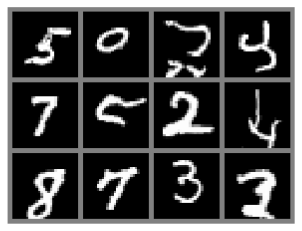

In [29]:
set_seed(1)
samples = model.sample(img_shape=(12,1,28,28))
show_imgs(samples.cpu())

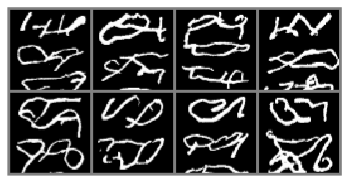

In [19]:
samples = model.sample(img_shape=(8,1,64,64))
show_imgs(samples.cpu())

### Visualization of predictive distribution (softmax)

In [20]:
imgs,_ = next(iter(train_loader))
imgs = imgs.to(device)
with torch.no_grad():
    out = model(imgs)
    out = F.softmax(out, dim=1)
    mean_out = out.mean(dim=[0,2,3,4]).cpu().numpy()
    out = out.cpu().numpy()

True distribution

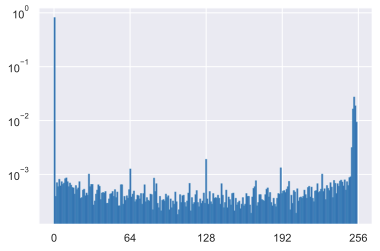

In [21]:
sns.set()
plt.hist(imgs.view(-1).cpu().numpy(), bins=256, edgecolor=(0.12,0.47,0.71,0.5), density=True)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

Predicted mean distribution

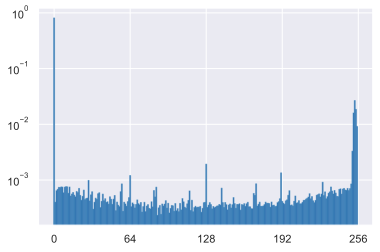

In [22]:
sns.set()
plt.bar(np.arange(mean_out.shape[0]), mean_out, edgecolor=(0.12,0.47,0.71,0.5))
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

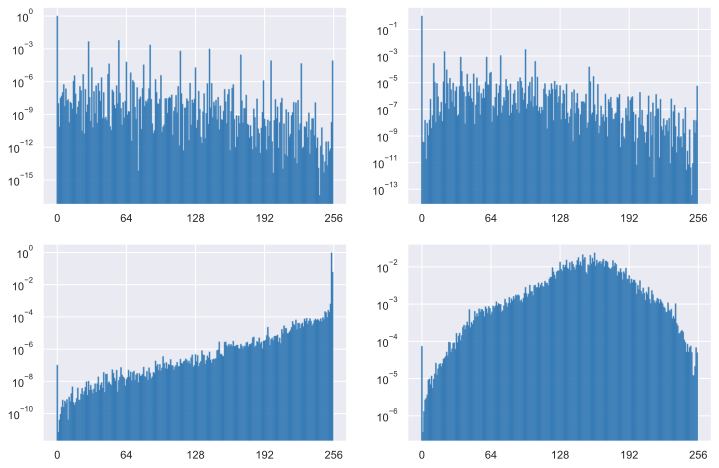

In [23]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    ax_sub = ax[i//2][i%2]
    ax_sub.bar(np.arange(out.shape[1], dtype=np.int32), out[i+4,:,0,14,14], edgecolor=(0.12,0.47,0.71,0.5))
    ax_sub.set_yscale("log")
    ax_sub.set_xticks([0,64,128,192,256])
plt.show()
plt.close()

### Autocompletion

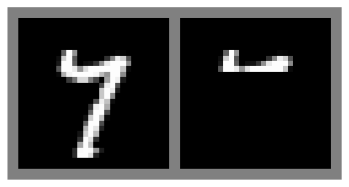

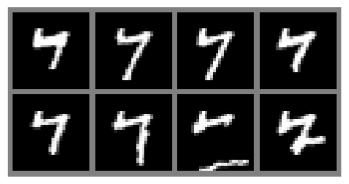

In [24]:
img = train_set[1][0]
img_init = img.clone()
img_init[:,10:,:] = -1
show_imgs([img,img_init.clamp(min=0)])

img_init = img_init.unsqueeze(dim=0).expand(8,-1,-1,-1).to(device)
img_generated = model.sample(img_init.shape, img_init)
show_imgs(img_generated)